# Import libarary

In [1]:
import os
import sys
import glob
import platform

import json
import pickle

import random
import math

from collections import OrderedDict
from functools import partial
from typing import Callable, Optional

from PIL import Image
import matplotlib.pyplot as plt
import cv2
import numpy as np

import torch
import torch.nn as nn
from torch import Tensor

import torch.optim as optim
import torch.optim.lr_scheduler as lr_scheduler
from torch.utils.tensorboard import SummaryWriter
from torchsummary import summary

from torch.utils.data import Dataset
import torchvision.transforms as transforms

from tqdm.notebook import tqdm

In [2]:
print(f"Pytorch version: {torch.__version__}")
if hasattr(nn, 'SiLU'):
    SiLU = nn.SiLU
    print("Support")
else:
    print("Not Support, for compatibility with old PyTorch versions")
    class SiLU(nn.Module):
        def forward(self, x):
            return x * torch.sigmoid(x)

Pytorch version: 1.8.1
Support


## Deep Networks with Stochastic Depth


In [3]:
#================================================= * Define DropPath Function * =================================================#

def drop_path(x, drop_prob: float = 0., training: bool = False):
    if drop_prob == 0. or not training:
        return x
    keep_prob = 1 - drop_prob
    shape = (x.shape[0],) + (1,) * (x.ndim - 1)  # work with diff dim tensors, not just 2D ConvNets
    random_tensor = keep_prob + torch.rand(shape, dtype = x.dtype, device = x.device)
    random_tensor.floor_()  # binarize
    output = x.div(keep_prob) * random_tensor
    return output

#=================================================== * Define Model Class * =====================================================#

class DropPath(nn.Module):
    def __init__(self, drop_prob = None):
        super(DropPath, self).__init__()
        self.drop_prob = drop_prob
    
    def forward(self, x):
        return drop_path(x, self.drop_prob, self.training)  

## Squeeze-and-Excitation(SE)

In [4]:
class SqueezeExcite(nn.Module):
    def __init__(self,
                 input_channels: int,   # <------- MBConv Input channels.
                 expand_channels: int,  # <------- SE Inputchannels (DW Output channels).
                 se_ratio: float = 0.25):        
        super(SqueezeExcite, self).__init__()
        
        
        squeeze_channels = int(input_channels * se_ratio)
        
        #============================================ * Avg Polling * ================================================#        
        self.avg_pool = nn.AdaptiveAvgPool2d(1)
        
        #=============================================== * FC1 * =====================================================#
        self.conv_reduce = nn.Conv2d(expand_channels, squeeze_channels, 1)
        self.act1 = SiLU()  # alias Swish
        
        #=============================================== * FC2 * =====================================================#
        self.conv_expand = nn.Conv2d(squeeze_channels, expand_channels, 1)
        self.act2 = nn.Sigmoid()

        
    def forward(self, x: Tensor) -> Tensor:
        #scale = x.mean((2, 3), keepdim=True) 
        scale = self.avg_pool(x)
        scale = self.conv_reduce(scale)      
        scale = self.act1(scale)           
        scale = self.conv_expand(scale)    
        scale = self.act2(scale)        
        return scale * x

## Define Conv + BN + Act  Layer

In [5]:
class ConvBNAct(nn.Module):
    def __init__(self,
                 in_channels: int,
                 out_channels: int,
                 kernel_size: int = 3,
                 stride: int = 1,
                 groups: int = 1,
                 norm_layer: Optional[Callable[..., nn.Module]] = None,
                 activation_layer: Optional[Callable[..., nn.Module]] = None):        
        super(ConvBNAct, self).__init__()

        padding = (kernel_size - 1) // 2        
        
        if norm_layer is None:
            norm_layer = nn.BatchNorm2d
        if activation_layer is None:
            activation_layer = SiLU

        self.conv = nn.Conv2d(in_channels  = in_channels,
                              out_channels = out_channels,
                              kernel_size  = kernel_size,
                              stride       = stride,
                              padding      = padding,
                              groups       = groups,
                              bias         = False)

        self.bn = norm_layer(out_channels)
        self.act = activation_layer()

    def forward(self, x):
        result = self.conv(x)
        result = self.bn(result)
        result = self.act(result)

        return result                                                                   

## MBConv Block

In [6]:
class MBConv(nn.Module):
    def __init__(self,
                 kernel_size: int,
                 in_channels: int,
                 out_channels: int,
                 expand_ratio: int,
                 stride: int,
                 se_ratio: float,
                 drop_rate: float,
                 norm_layer: Callable[..., nn.Module]):
        super(MBConv, self).__init__()
       
        
        if stride not in [1, 2]:
            raise ValueError("illegal stride value.")
            
        self.out_channels = out_channels       
        self.drop_rate = drop_rate

        self.has_shortcut = (stride == 1 and in_channels == out_channels)

        activation_layer = SiLU
        
        assert expand_ratio != 1
        
        #expand width
        expanded_channels = in_channels * expand_ratio
        
           
        #====================================================== * Point-wise Expansion(1x1, s1) * ==================================================#
        # in:*para-IN* || out:*para-IN* x ratio || kernel:1 || stride: 1 || group: 1 || Nomormal: *para*(BN) || Act: SiLu
        
        self.expand_conv = ConvBNAct(in_channels      = in_channels,
                                     out_channels     = expanded_channels,
                                     kernel_size      = 1,
                                     norm_layer       = norm_layer,
                                     activation_layer = activation_layer)
      
        #==================================================== * Depth-wise convolution(3x3, s1/s2) * ===============================================#
        # in:*para-IN* x ratio || out:*para-IN* x ratio || kernel: *para* || stride: *para* || group: *para-IN* x ratio || Nomormal: *para*(BN) || Act: SiLu
        
        self.dwconv = ConvBNAct(in_channels      = expanded_channels,
                                out_channels     = expanded_channels,
                                kernel_size      = kernel_size,
                                stride           = stride,
                                groups           = expanded_channels,
                                norm_layer       = norm_layer,
                                activation_layer = activation_layer)

        #======================================================== * Squeeze-and-Excitation(SE) * ===================================================#
        # input_channel:*para-IN*(MBConv-IN) || expanded_channel: *para-IN* x ratio(DW-OUT)
        
        self.SE = SqueezeExcite(input_channels   = in_channels,
                                expand_channels  = expanded_channels,
                                se_ratio         = se_ratio) if se_ratio > 0 else nn.Identity()
        
        #======================================================= * Point-wise linear projection * ==================================================#
        # in:*para-IN* x ratio || out: *para-OUT* || kernel: 1 || stride: 1 || group: 1 || Nomormal: *para*(BN) || Act: None
        
        self.project_conv = ConvBNAct(in_channels       = expanded_channels,
                                      out_channels      = out_channels,
                                      kernel_size       = 1,
                                      norm_layer        = norm_layer,
                                      activation_layer  = nn.Identity)  


        #================================================================ * Drop Path * ============================================================#
        # Use the dropout layer only when using the shortcut.
        if self.has_shortcut and drop_rate > 0:
            self.dropout = DropPath(drop_rate)

            
    def forward(self, x: Tensor) -> Tensor:
        result = self.expand_conv(x)
        result = self.dwconv(result)
        result = self.SE(result)
        result = self.project_conv(result)

        if self.has_shortcut:
            if self.drop_rate > 0:
                result = self.dropout(result)
            result += x

        return result

## Fused-MBConv Block

In [7]:
class FusedMBConv(nn.Module):
    def __init__(self,
                 kernel_size: int,
                 in_channels: int,
                 out_channels: int,
                 expand_ratio: int,
                 stride: int,
                 se_ratio: float,
                 drop_rate: float,
                 norm_layer: Callable[..., nn.Module]):
        super(FusedMBConv, self).__init__()

        
        assert stride in [1, 2]
        assert se_ratio == 0

        self.out_channels = out_channels        
        self.drop_rate = drop_rate
        
        self.has_shortcut = (stride == 1 and in_channels == out_channels)

        activation_layer = SiLU  
        
        expanded_channels = in_channels * expand_ratio
        
        self.has_expansion = (expand_ratio != 1)
        
        
        ################################################################### * Expansion != 1 * ###########################################################
        if self.has_expansion:
            
            #===================================================== * Expansion convolution(3x3, s1/S2) * ===============================================#
            # in:*para-IN* || out:*para-IN* x ratio || kernel: *para* || stride: *para* || group: 1 || Nomormal: *para*(BN) || Act: SiLu
            self.expand_conv = ConvBNAct(in_channels      = in_channels,
                                         out_channels     = expanded_channels,
                                         kernel_size      = kernel_size,
                                         stride           = stride,
                                         norm_layer       = norm_layer,
                                         activation_layer = activation_layer)
            
            #==================================================== * Point-wise linear projection(1x1, s1) * ============================================#
            # in:*para-IN* x ratio || out:*para-OUT* || kernel: 1 || stride: 1 || group: 1 || Nomormal: *para*(BN) || Act: None
            self.project_conv = ConvBNAct(in_channels      = expanded_channels,
                                          out_channels     = out_channels,
                                          kernel_size      = 1,
                                          norm_layer       = norm_layer,
                                          activation_layer = nn.Identity)  # There is no activation function, so use Identity (empty layer)
            
       
        ################################################################### * Expansion = 1 * ############################################################
        # When only project_conv exists.
        else:
            
            #=================================================== * Point-wise linear projection(3x3, s1/s2) * ==========================================#
            # in:*para-IN* || out:*para-OUT* || kernel: *para* || stride: *para* || group: 1 || Nomormal: *para*(BN) || Act: SiLu
            self.project_conv = ConvBNAct(in_channels      = in_channels,
                                          out_channels     = out_channels,
                                          kernel_size      = kernel_size,
                                          stride           = stride,
                                          norm_layer       = norm_layer,
                                          activation_layer = activation_layer)  # There is activation function.

        
        #=================================================================== * Drop Path * =============================================================#
        # Use the dropout layer only when using the shortcut.
        if self.has_shortcut and drop_rate > 0:
            self.dropout = DropPath(drop_rate)

            
    def forward(self, x: Tensor) -> Tensor:
        if self.has_expansion:
            result = self.expand_conv(x)
            result = self.project_conv(result)
        else:
            result = self.project_conv(x)

        if self.has_shortcut:
            if self.drop_rate > 0:
                result = self.dropout(result)
            result += x

        return result

# Define Efficentv2 Base Model


In [8]:
class EfficientNetV2(nn.Module):
    def __init__(self,
                 model_cnf: list,
                 num_classes: int = 1000,
                 num_features: int = 1280,
                 dropout_rate: float = 0.2,
                 drop_connect_rate: float = 0.2):
        super(EfficientNetV2, self).__init__()

        for cnf in model_cnf:
            assert len(cnf) == 8

        norm_layer = partial(nn.BatchNorm2d, eps = 1e-3, momentum=0.1)
        
        
        #========================================================= * Stage 0 * =========================================================#
        # Stage0 Conv (In: 3(RGB Image) || Out: stage1-IN || kernel: 3 || stride: 2 || norm: BN || Act: SiLu)
        
        self.stem = ConvBNAct(in_channels = 3,
                              out_channels = model_cnf[0][4],
                              kernel_size = 3,
                              stride = 2,
                              norm_layer = norm_layer)  
        
        #======================================================== * Stage 1-6 * ========================================================#
        
        total_blocks = sum([i[0] for i in model_cnf])
        block_id = 0
        blocks = []       
        for cnf in model_cnf:
            repeats = cnf[0]
            Operator_FMBConv = FusedMBConv if cnf[-2] == 0 else MBConv
            for i in range(repeats):
                blocks.append(Operator_FMBConv( kernel_size    = cnf[1],
                                                in_channels = cnf[4] if i == 0 else cnf[5],
                                                out_channels   = cnf[5],
                                                expand_ratio   = cnf[3],
                                                stride         = cnf[2] if i == 0 else 1,
                                                se_ratio       = cnf[-1],
                                                drop_rate      = drop_connect_rate * block_id / total_blocks,
                                                norm_layer     = norm_layer))
                block_id += 1                
        self.blocks = nn.Sequential(*blocks)
        
        #========================================================= * Stage 7 * =========================================================#
        
        head = OrderedDict()

        head.update({"project_conv": ConvBNAct(in_channels  = model_cnf[-1][-3],
                                               out_channels = num_features,
                                               kernel_size  = 1,
                                               norm_layer   = norm_layer)})

        head.update({"avgpool": nn.AdaptiveAvgPool2d(1)})
        
        head.update({"flatten": nn.Flatten()})

        if dropout_rate > 0:
            head.update({"dropout": nn.Dropout(p = dropout_rate, inplace=True)})
            
        head.update({"classifier": nn.Linear(num_features, num_classes)})

        self.head = nn.Sequential(head)
        
        #====================================================== * Initial Weights * =====================================================#
        
        for m in self.modules():
            
            if isinstance(m, nn.Conv2d):
                nn.init.kaiming_normal_(m.weight, mode = "fan_out")
                if m.bias is not None:
                    nn.init.zeros_(m.bias)
                    
            elif isinstance(m, nn.BatchNorm2d):
                nn.init.ones_(m.weight)
                nn.init.zeros_(m.bias)
                
            elif isinstance(m, nn.Linear):
                nn.init.normal_(m.weight, 0, 0.01)
                nn.init.zeros_(m.bias)

                
    def forward(self, x: Tensor) -> Tensor:
        x = self.stem(x)
        x = self.blocks(x)
        x = self.head(x)

        return x

---

# EfficientNetV2_S Model


In [9]:
def efficientnetv2_s(num_classes: int = 1000):

    
    model_config = [[2, 3, 1, 1, 24, 24, 0, 0],
                    [4, 3, 2, 4, 24, 48, 0, 0],
                    [4, 3, 2, 4, 48, 64, 0, 0],
                    [6, 3, 2, 4, 64, 128, 1, 0.25],
                    [9, 3, 1, 6, 128, 160, 1, 0.25],
                    [15, 3, 2, 6, 160, 256, 1, 0.25]]

    model = EfficientNetV2(model_cnf    = model_config,
                           num_classes  = num_classes,
                           dropout_rate = 0.2)
    return model

# EfficientNetV2_M Model


In [10]:
def efficientnetv2_m(num_classes: int = 1000):
    
    model_config = [[3, 3, 1, 1, 24, 24, 0, 0],
                    [5, 3, 2, 4, 24, 48, 0, 0],
                    [5, 3, 2, 4, 48, 80, 0, 0],
                    [7, 3, 2, 4, 80, 160, 1, 0.25],
                    [14, 3, 1, 6, 160, 176, 1, 0.25],
                    [18, 3, 2, 6, 176, 304, 1, 0.25],
                    [5, 3, 1, 6, 304, 512, 1, 0.25]]

    model = EfficientNetV2(model_cnf    = model_config,
                           num_classes  = num_classes,
                           dropout_rate = 0.3)
    return model


# EfficientNetV2_L Model


In [11]:
def efficientnetv2_l(num_classes: int = 1000):
    
    model_config = [[4, 3, 1, 1, 32, 32, 0, 0],
                    [7, 3, 2, 4, 32, 64, 0, 0],
                    [7, 3, 2, 4, 64, 96, 0, 0],
                    [10, 3, 2, 4, 96, 192, 1, 0.25],
                    [19, 3, 1, 6, 192, 224, 1, 0.25],
                    [25, 3, 2, 6, 224, 384, 1, 0.25],
                    [7, 3, 1, 6, 384, 640, 1, 0.25]]

    model = EfficientNetV2(model_cnf     = model_config,
                           num_classes   = num_classes,
                           dropout_rat   = 0.4)
    return model

---
# Data preprocess

#### Create Folder

#### Define  Torch DataSet class

In [12]:
class MyDataSet(Dataset):
    def __init__(self, images_path: list, images_class: list, transform=None):
        self.images_path = images_path
        self.images_class = images_class
        self.transform = transform

    def __len__(self):
        return len(self.images_path)

    def __getitem__(self, item):
        img = Image.open(self.images_path[item])

        if img.mode == 'RGBA':
            img = img.convert('RGB')
        if img.mode != 'RGB':        
            raise ValueError(f"image: {self.images_path[item]} isn't RGB mode.")
            
        label = self.images_class[item]

        if self.transform is not None:
            img = self.transform(img)

        return img, label
    
    @staticmethod
    def collate_fn(batch):
        images, labels = tuple(zip(*batch))

        images = torch.stack(images, dim=0)
        labels = torch.as_tensor(labels)
        return images, labels

#### * Preprocess function *

In [13]:
def read_split_data(root: str, val_rate: float = 0.2, plot_image: bool = False):
    
    random.seed(0) 
    assert os.path.exists(root), f"dataset root: {root} does not exist."

    data_class = [cla for cla in os.listdir(root) if os.path.isdir(os.path.join(root, cla))]
    
    data_class.sort()
    
    class_indices = dict((classname, index) for index, classname in enumerate(data_class))
    
    json_str = json.dumps(dict((val, key) for key, val in class_indices.items()), indent = 4)
    with open('class_indices.json', 'w') as json_file:
        json_file.write(json_str)

    train_images_path = []     # Training dataset image path.
    train_images_label = []    # Training dataset image label(index).
    val_images_path = []       # Validation dataset image path.
    val_images_label = []      # Validation dataset image label(index).
    each_class_tataldata = []  # Total number of data in each class.
    
    supported = [".jpg", ".JPG", ".png", ".PNG"]  
    
    for classname in data_class:

        class_folderpath = os.path.join(root, classname)

        images = [os.path.join(root, classname, imagefile) for imagefile in os.listdir(class_folderpath)
                  if os.path.splitext(imagefile)[-1] in supported]
        
        image_class = class_indices[classname]
        
        each_class_tataldata.append(len(images))
        
        val_path = random.sample(images, k = int(len(images) * val_rate))

        
        for img_path in images:  
            
            if img_path in val_path:  
                val_images_path.append(img_path)
                val_images_label.append(image_class) 
                
            else:  
                train_images_path.append(img_path)
                train_images_label.append(image_class)

                
    print(f"{sum(each_class_tataldata)} images were found in the dataset.")
    print(f"{len(train_images_path)} images for training.")
    print(f"{len(val_images_path)} images for validation.")

    if plot_image:
        plt.bar(range(len(data_class)), each_class_tataldata, align='center')
        plt.xticks(range(len(data_class)), data_class)
        for i, v in enumerate(each_class_tataldata):
            plt.text(x=i, y=v + 5, s=str(v), ha='center')
        plt.xlabel('image class')
        plt.ylabel('number of images')
        plt.title('flower class distribution')
        plt.show()

    return train_images_path, train_images_label, val_images_path, val_images_label

---

# Training

In [14]:
if os.path.exists("../dataset") is False:
    os.makedirs("../dataset")
    print("Create folder")
else:
    print("Folder has been exist!")

Folder has been exist!


## -- Set  Hyperparameters --

In [15]:
type_model = "s" 

datapath = "../dataset/fire_daraset_classification_compression/"

num_classes = 2
total_epochs = 1000

batch_size = 8
lr = 1e-3 # Default 0.01
lr_min = 0.01 # Multiplier factor 1 -> 0.01

weights_path = "../pre-train/model-30.pth"
freeze_layers = False
device_used = "cuda:0"

save_interval = 1

if os.path.exists("../weights") is False:
    os.makedirs("../weights")
    print("Make weight saved folder.")

#save_weight_root = "./weights"  
save_weight_root = "../weights"   

#### Set up the cuda environment

In [16]:
device = torch.device( device_used if torch.cuda.is_available() else "cpu")
device

device(type='cuda', index=0)

#### Get the DataSet - train & valid

In [17]:
train_images_path, train_images_label, val_images_path, val_images_label = read_split_data(datapath)

2371 images were found in the dataset.
1897 images for training.
474 images for validation.


#### Set the input size of the image according to the model type.

In [18]:
img_size = {"s": [300, 384],  
            "m": [384, 480],
            "l": [384, 480]}

##  Init Dataset & Image Augmentation


In [19]:
#=========================================== * Image Augmentation * ===============================================#

data_transform = {
    "train": transforms.Compose([transforms.RandomResizedCrop(img_size[type_model][0]),
                                 transforms.RandomHorizontalFlip(),
                                 transforms.ToTensor(),
                                 transforms.Normalize([0.5, 0.5, 0.5], [0.5, 0.5, 0.5])]),

    "val": transforms.Compose([transforms.Resize(img_size[type_model][1]),
                               transforms.CenterCrop(img_size[type_model][1]),
                               transforms.ToTensor(),
                               transforms.Normalize([0.5, 0.5, 0.5], [0.5, 0.5, 0.5])])}

#=============================================== * Init Dataset * =================================================#

train_dataset = MyDataSet(images_path=train_images_path,
                          images_class=train_images_label,
                          transform=data_transform["train"])

val_dataset = MyDataSet(images_path=val_images_path,
                        images_class=val_images_label,
                        transform=data_transform["val"])

#============================================ * Calculate NumWorkers * ============================================#

if platform.system().casefold() == 'windows':
    numworkers = 0
    print("platfrom windows")
    
elif platform.system().casefold() == 'linux':
    numworkers = min([os.cpu_count(), batch_size if batch_size > 1 else 0, 8])  # number of workers
    print("platfrom linux")

print(f'Using {numworkers} dataloader workers every process')

#============================================== * Init Dataloader * ===============================================#

train_loader = torch.utils.data.DataLoader(train_dataset,
                                           batch_size  = batch_size,
                                           shuffle     = True,
                                           pin_memory  = True,
                                           num_workers = numworkers,
                                           collate_fn  = train_dataset.collate_fn)

val_loader = torch.utils.data.DataLoader(val_dataset,
                                         batch_size  = batch_size,
                                         shuffle     = False,
                                         pin_memory  = True,
                                         num_workers = numworkers,
                                         collate_fn  = val_dataset.collate_fn)

platfrom windows
Using 0 dataloader workers every process


## Define Model

##### Init Model

In [20]:
if type_model.casefold() == 's':
    model = efficientnetv2_s(num_classes = num_classes).to(device)
    print("Use EfficientnetV2_S")
    
elif type_model.casefold() == 'm':
    model = efficientnetv2_m(num_classes = num_classes).to(device)
    print("Use EfficientnetV2_M")
    
elif type_model.casefold() == 'l':
    model = efficientnetv2_l(num_classes = num_classes).to(device)
    print("Use EfficientnetV2_L")
    
else:
    raise ValueError("Cannot be empty, or input type format error!")
    
#summary(model.cuda(), (3, img_size[type_model][0], img_size[type_model][1]))

Use EfficientnetV2_S


#### Load if there are pre-training weights

In [21]:
if weights_path != "":
    if os.path.exists(weights_path):
        weights_dict = torch.load(weights_path, map_location = device)
        load_weights_dict = {k: v for k, v in weights_dict.items()
                             if model.state_dict()[k].numel() == v.numel()}
        print(model.load_state_dict(load_weights_dict, strict = False))
    else:
        raise FileNotFoundError(f"not found weights file: {weights_path}")

<All keys matched successfully>


#### Whether to freeze weight or not

In [22]:
if freeze_layers:
    for name, para in model.named_parameters():
        if "head" not in name:
            para.requires_grad_(False)
        else:
            print(f"training {name}")

## Define Optimizer

In [23]:
model_param = [p for p in model.parameters() if p.requires_grad]
optimizer = optim.SGD(model_param, lr = lr, momentum = 0.9, weight_decay = 1e-4)

lr_lambda = lambda step: ((1 + math.cos(step * math.pi / total_epochs)) / 2) * (1 - lr_min) + lr_min  
scheduler = lr_scheduler.LambdaLR(optimizer, lr_lambda = lr_lambda)

## Define Training Function

#### Define train one epoch function

In [24]:
def train_one_epoch(model, optimizer, data_loader, device, epoch):
    
    model.train()
    
    loss_function = torch.nn.CrossEntropyLoss()
    
    accu_loss = torch.zeros(1).to(device)  # Accumulate loss value.
    accu_num = torch.zeros(1).to(device)   # Accumulate the number of samples correctly predicted.
    
    optimizer.zero_grad()

    sample_num = 0
    data_loader_progress_bar = tqdm(data_loader, file = sys.stdout)
    for step, data in enumerate(data_loader_progress_bar):
        images, labels = data
        sample_num += images.shape[0]

        output = model(images.to(device))
        pred_classes = torch.max(output, dim=1)[1]
        accu_num += torch.eq(pred_classes, labels.to(device)).sum()

        loss = loss_function(output, labels.to(device))
        loss.backward()
        accu_loss += loss.detach()

        data_loader_progress_bar.desc = f"[Epoch {epoch}] Loss: {accu_loss.item() / (step + 1):.3f}, Acc: {accu_num.item() / sample_num:.3f}"

        if not torch.isfinite(loss):
            print('WARNING: non-finite loss, ending training ', loss)

        optimizer.step()
        optimizer.zero_grad()

    return accu_loss.item() / (step + 1), accu_num.item() / sample_num

#### Define evaluate model function

In [25]:
@torch.no_grad()
def evaluate(model, data_loader, device, epoch):
    
    model.eval()
    
    loss_function = torch.nn.CrossEntropyLoss()
    
    accu_loss = torch.zeros(1).to(device)  # Accumulate loss value.
    accu_num = torch.zeros(1).to(device)   # Accumulate the number of samples correctly predicted.
    
    sample_num = 0
    data_loader = tqdm(data_loader, file = sys.stdout)
    for step, data in enumerate(data_loader):
        images, labels = data
        sample_num += images.shape[0]

        output = model(images.to(device))
        pred_classes = torch.max(output, dim=1)[1]
        accu_num += torch.eq(pred_classes, labels.to(device)).sum()

        loss = loss_function(output, labels.to(device))
        accu_loss += loss

        data_loader.desc = f"[Valid Epoch {epoch}] Loss: {accu_loss.item() / (step + 1) :.3f}, Acc: {accu_num.item() / sample_num :.3f}"        

    return accu_loss.item() / (step + 1), accu_num.item() / sample_num

### Training Function

In [26]:
def training_model():
    for epoch in range(total_epochs):
        # train
        train_loss, train_acc = train_one_epoch(model       = model,
                                                optimizer   = optimizer,
                                                data_loader = train_loader,
                                                device      = device,
                                                epoch       = epoch)

        scheduler.step()

        # validate
        val_loss, val_acc = evaluate(model       = model,
                                     data_loader = val_loader,
                                     device      = device,
                                     epoch       = epoch)


        tags = ["train_loss", "train_acc", "val_loss", "val_acc", "learning_rate"]
        tb_writer.add_scalar(tags[0], train_loss, epoch)
        tb_writer.add_scalar(tags[1], train_acc, epoch)
        tb_writer.add_scalar(tags[2], val_loss, epoch)
        tb_writer.add_scalar(tags[3], val_acc, epoch)
        tb_writer.add_scalar(tags[4], optimizer.param_groups[0]["lr"], epoch)

        
        if epoch % save_interval == 0:
            savefile = f"model-{epoch}.pth"
            torch.save(model.state_dict(), os.path.join(save_weight_root, savefile))
        elif epoch == total_epochs-1:
            savefile = f"model-last.pth"
            torch.save(model.state_dict(), os.path.join(save_weight_root, savefile))

#### Use TensorBoard

In [27]:
print('Start Tensorboard with "tensorboard --logdir=logs", view at http://localhost:6006/')
tb_writer = SummaryWriter("logs")

Start Tensorboard with "tensorboard --logdir=logs", view at http://localhost:6006/


In [ ]:
training_model()
tb_writer.flush()

In [ ]:
tb_writer.close()

---

# Test

#### Define predict function

In [ ]:
def predict_model(img, label_json, weights):
    data_transform = transforms.Compose([
                                         transforms.Resize(img_size[type_model][1]),
                                         transforms.CenterCrop(img_size[type_model][1]),
                                         transforms.ToTensor(),
                                         transforms.Normalize([0.5, 0.5, 0.5], [0.5, 0.5, 0.5])])

    # load image
    img_path = img
    assert os.path.exists(img_path), f"file: '{img_path}' dose not exist."
    img = Image.open(img_path)
    plt.imshow(img)

    img = data_transform(img)

    img = torch.unsqueeze(img, dim=0)

    json_path = label_json
    assert os.path.exists(json_path), f"file: '{json_path}' dose not exist."
    json_file = open(json_path, "r")
    class_indict = json.load(json_file)

    # create model
    #model = model(num_classes=5).to(device)

    # load model weights
    model_weight_path = weights
    model.load_state_dict(torch.load(model_weight_path, map_location = device))

    # predict class
    model.eval()
    with torch.no_grad():
        output = torch.squeeze(model(img.to(device))).cpu()
        predict = torch.softmax(output, dim = 0)
        predict_cla = torch.argmax(predict).numpy()

    # result    
    print_result = f"class: {class_indict[str(predict_cla)]}   prob: {predict[predict_cla].numpy() :.3}"
    plt.title(print_result)
    for i in range(len(predict)):
        print(f"class: {class_indict[str(i)] :10}   prob: {predict[i].numpy() :.3}")

    plt.show()

class: daisy        prob: 0.0631
class: dandelion    prob: 0.0036
class: roses        prob: 0.0259
class: sunflowers   prob: 0.000833
class: tulips       prob: 0.907


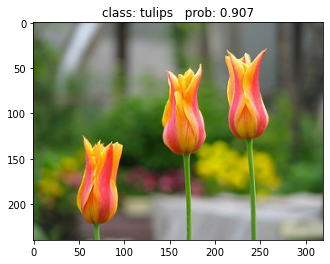

In [ ]:
predict_model(img        = "./dataset/flower_photos/tulips/146884869_b1a8fa9c4e_n.jpg",
              label_json = './class_indices.json',
              weights    = "./weights/model-29.pth", )